# Estimation of FRET efficiency for emission from WS2 and absorption by diamond NV- center.

Based on Medintz & Hildebrandt, 2014, pages 23-31.

FRET efficiency, $E$, is
$$
E = \frac{R_0^6}{R_0^6 + r_{DA}^6}
$$
where
$r_{DA}$ is the distance between donor and acceptor
and 
$R_0$ is the Förster distance.
This is also expressed as
$$
E = \frac{k_T}{k_T + 1/\tau_D}
$$
where
$k_T$ is the rate of energy transfer
and $t_D$ is the lifetime of the donor excited state in the absence of acceptor.
The formula for $k_T$ is
$$
k_T = \frac{1}{\tau_D} \left( \frac{R_0^6}{r_{DA}^6} \right)
$$

The Förster distance $R_0^6$ is a key quantity to compute,
and is given as
$$
R_0^6 = \frac{9 (\ln 10) \kappa^2 \Phi_D J }{128\pi^5 n^4 N_A}
$$
where $\kappa^2$ is the orientation factor,
$\Phi_D$ is the quantum yield of the donor fluorescence in the absence of acceptor,
$J$ is the overlap integral,
$\pi = 3.14159...$,
$n$ is the index of refraction of the medium,
and $N_A$ is the Avogadro number $6.0221415 \times 10^{23}$ per mol.

The overlap integral $J$, is computed differently depending on whether the spectra are given in terms of wavelength, wave number, or frequency. For wavelength,
$$
J^\lambda = J = \int f_D(\lambda) \epsilon_A(\lambda) \lambda^4 \mathrm{d} \lambda
$$
where $f_D(\lambda)$ is the fluorescence spectrum of the donor,
$\epsilon_A(\lambda)$ is the molar extinction coefficient (a.k.a. molar absorptivity) of the acceptor (usually in units of $\mathrm{M}^{-1} \mathrm{cm}^{-1}$), and $\lambda$ is the wavelength (usually in nm).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

## WS2 emission spectrum

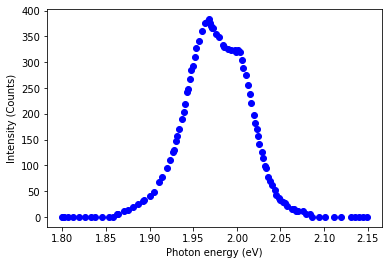

In [35]:
WS2_eV, WS2_intensity, _, _, _, _ = np.loadtxt("WS2_emission.txt", unpack=True)
plt.clf()
plt.scatter(WS2_eV, WS2_intensity,color="blue")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (Counts)");

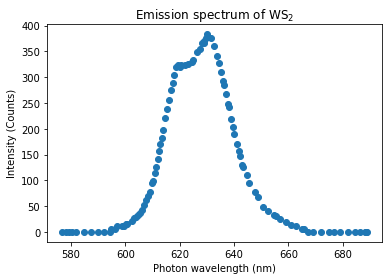

In [34]:
hc = 1239.8 # eV nm
WS2_nm = hc/WS2_eV
plt.clf()
plt.scatter(WS2_nm, WS2_intensity,color="tab:blue")
plt.title("Emission spectrum of $\mathrm{WS_2}$")
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Intensity (Counts)");

## NV- center absorption spectrum

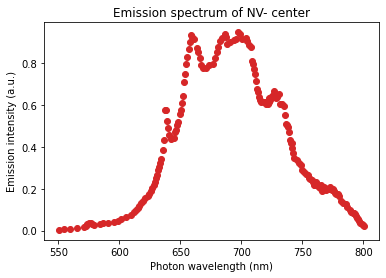

In [31]:
nv_center_emission_nm, nv_center_emission_intensity, _, _, _, _ = np.loadtxt("NV_center_emission.txt", unpack=True)
plt.clf()
plt.scatter(nv_center_emission_nm, nv_center_emission_intensity,color="tab:red")
plt.title("Emission spectrum of NV- center")
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Emission intensity (a.u.)");

Compare to Figure 7 of Wee et al., 2007:

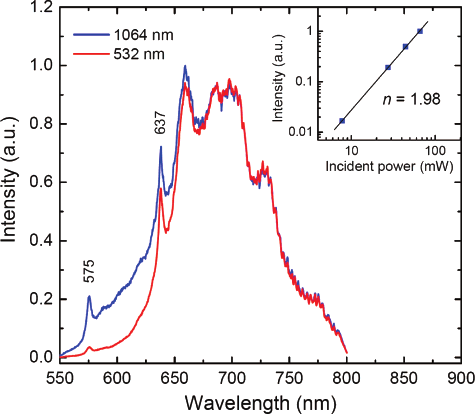

In [5]:
IPython.display.Image(filename="nv-center-excitation-spectrum/fig7.png")

> Figure 7. Comparison of one-photon and two-photon excited fluorescence spectra of nitrogen-vacancy centers in type Ib diamond treated with 3 MeV proton irradiation.

> Figure 7 displays the emission spectra of the (N-V)⁻ centers excited by 532 and 1064 nm laser pulses at room temperature for a sample prepared with the 3 MeV proton irradiation. Both spectra were collected at an excitation time of 4 s using a 40× microscope objective with an incident laser power of 0.08 μW and 4.6 mW for the one-photon and two-photon excitations, respectively. In addition to the ZPL of the (N-V)⁻ center at 637 nm, a sharp ZPL derived from the (N-V)⁰ center can be found at 575 nm (2.156 eV) in both spectra. Interestingly, this center cannot be identified in the absorption spectrum even at 80 K (Figure 6b) but reveals itself clearly in the emission profile.

Since this is the emission spectrum of the diamond NV- center, not the absorption / excitation spectrum, we will need to flip the spectrum around the zero phonon line at 637 nm to approximate the absorption spectrum.

In [6]:
nv_center_absorption_nm = 637 - (nv_center_emission_nm - 637)

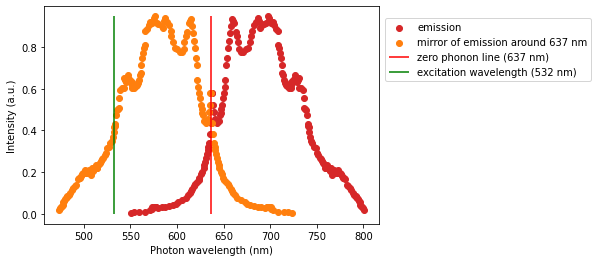

In [33]:
plt.clf()
plt.scatter(nv_center_emission_nm, nv_center_emission_intensity, label="emission", color="tab:red")
plt.scatter(nv_center_absorption_nm, nv_center_emission_intensity, label="mirror of emission around 637 nm", color="tab:orange")
plt.vlines(x=637, ymin=0, ymax=max(nv_center_emission_intensity), color="red", label="zero phonon line (637 nm)")
plt.vlines(x=532, ymin=0, ymax=max(nv_center_emission_intensity), color="green", label="excitation wavelength (532 nm)")
plt.legend(loc="center right", bbox_to_anchor=(1.65,0.8))
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Intensity (a.u.)");

Compare the [image](https://commons.wikimedia.org/wiki/File:NVple.JPG) from the [Wikipedia page for NV centers](https://en.wikipedia.org/wiki/Nitrogen-vacancy_center):

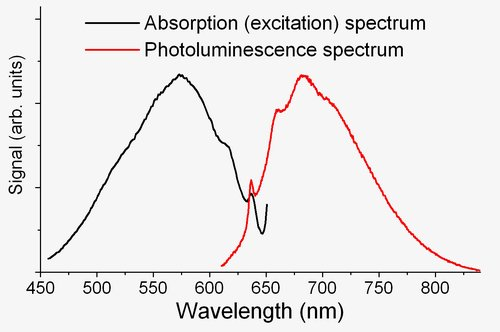

In [8]:
IPython.display.Image(filename="NVple.JPG")

The NV- spectrum has a one-photon absorption cross section specified at 532 nm, so we should normalize the spectrum so that it has the correct absorption at that value.

In [9]:
i_closest_to_532nm = np.abs(532 - nv_center_absorption_nm).argmin()
intensity_closest_to_532nm = nv_center_emission_intensity[i_closest_to_532nm]
nv_center_absorption_intensity = nv_center_emission_intensity/intensity_closest_to_532nm

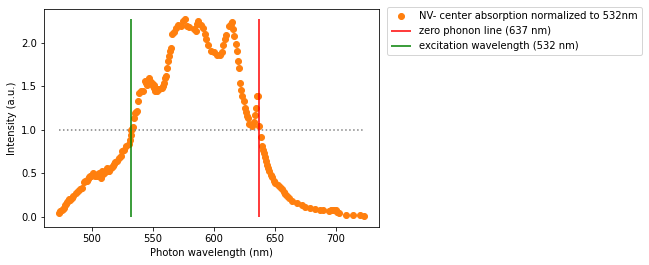

In [36]:
plt.clf()
plt.hlines(y=1.0, xmin=min(nv_center_absorption_nm), xmax=max(nv_center_absorption_nm), color="gray", linestyles="dotted")
plt.scatter(nv_center_absorption_nm, nv_center_absorption_intensity, color="tab:orange", label="NV- center absorption normalized to 532nm")
plt.vlines(x=637, ymin=0, ymax=max(nv_center_absorption_intensity), color="red", label="zero phonon line (637 nm)")
plt.vlines(x=532, ymin=0, ymax=max(nv_center_absorption_intensity), color="green", label="excitation wavelength (532 nm)")
plt.legend(loc="center right", bbox_to_anchor=(1.8,0.9))
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Intensity (a.u.)");

Now let's see what the $\mathrm{WS_2}$ emission looks like overlaid on the NV- center absorption spectrum.

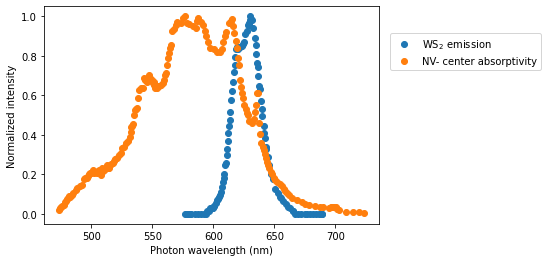

In [37]:
plt.clf()
plt.scatter(WS2_nm, WS2_intensity/WS2_intensity.max(), label="$\mathrm{WS}_2$ emission", color="tab:blue")
plt.scatter(nv_center_absorption_nm, nv_center_absorption_intensity/nv_center_absorption_intensity.max(), color="tab:orange", label="NV- center absorptivity")
plt.xlabel("Photon wavelength (nm)")
plt.legend(loc="best", bbox_to_anchor=(1.5,0.9));
plt.ylabel("Normalized intensity");

## Overlap integral

In [12]:
def overlap_OLI(
        donor_lambda,
        donor_fluorescence,
        acceptor_lambda,
        acceptor_extinction,
        molar_attenuation_coefficient):
    # In this method, we run over donor lambdas.
    assert len(donor_lambda) == len(donor_fluorescence)
    assert len(acceptor_lambda) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    donor_norm = donor_fluorescence/donor_fluorescence.max()
    # Peak-normalize acceptor.
    acceptor_norm = acceptor_extinction/acceptor_extinction.max()
    # Only go over the overlapping lambda range.
    lambda_min = max(donor_lambda.min(),acceptor_lambda.min())
    lambda_max = min(donor_lambda.max(),acceptor_lambda.max())
    wavelengths = []
    J_raw = []
    for i, wavelength_nm in enumerate(donor_lambda):
        if wavelength_nm < lambda_min:
            continue
        elif wavelength_nm > lambda_max:
            continue
        wavelengths.append(wavelength_nm)
        f_D = donor_norm[i]
        # Find index of closest corresponding wavelength in acceptor_lambda.
        # TODO: issue a warning if the acceptor data is too sparse.
        j = np.abs(acceptor_lambda - wavelength_nm).argmin()
        # eps_A has units of 1/(M cm)
        eps_A = acceptor_norm[j]*molar_attenuation_coefficient
        # OLI is 10^14 M^-1 cm^-1 nm^4
        J_val = 1e-14 * f_D * eps_A * (wavelength_nm**4)
        J_raw.append(J_val)
    lambda_J = np.array(wavelengths)
    J = np.array(J_raw) / donor_norm.sum()
    return lambda_J, J

We need to relate the absorption cross section $\sigma$ an NV- center to the molar attenuation coefficient $\epsilon_A$.

$$\epsilon_A = \frac{N_A}{\ln 10} \sigma$$

In [13]:
nv_center_absorption_cross_section = 3.1e-17 # cm^2/defect
N_A = 6.02214076e23 # defect/mol
molar_attenuation_coefficient_raw = N_A*nv_center_absorption_cross_section/math.log(10) # cm^2/mol
cm2_per_mol_to_inverse_molar_cm = 1/1000.
molar_attenuation_coefficient = molar_attenuation_coefficient_raw*cm2_per_mol_to_inverse_molar_cm # 1/(M cm)
print("{:.3g} M^-1 cm^-1".format(molar_attenuation_coefficient))

8.11e+03 M^-1 cm^-1


In [14]:
lambda_J, J_OLI = overlap_OLI(
    WS2_nm,
    WS2_intensity,
    nv_center_absorption_nm,
    nv_center_absorption_intensity,
    molar_attenuation_coefficient)

In [15]:
J_sum_OLI = J_OLI.sum()
print("J = {:.4g} * 10^14 M^-1 cm^-1 nm^4 (OLI)".format(J_sum_OLI))

J = 7.58 * 10^14 M^-1 cm^-1 nm^4 (OLI)


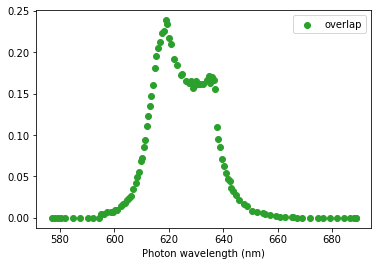

In [38]:
plt.clf()
plt.scatter(lambda_J, J_OLI, label="overlap",color="tab:green")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

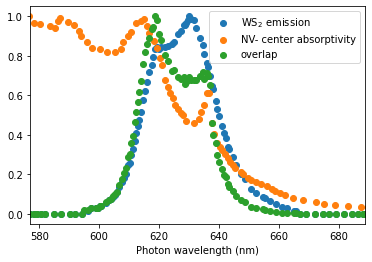

In [39]:
plt.clf()
plt.scatter(WS2_nm, WS2_intensity/WS2_intensity.max(), color="tab:blue", label="$\mathrm{WS}_2$ emission")
plt.scatter(nv_center_absorption_nm, nv_center_absorption_intensity/nv_center_absorption_intensity.max(), color="tab:orange", label="NV- center absorptivity")
plt.scatter(lambda_J, J_OLI/J_OLI.max(), label="overlap", color="tab:green")
plt.legend()
plt.xlim(min(lambda_J),max(lambda_J))
plt.xlabel("Photon wavelength (nm)");

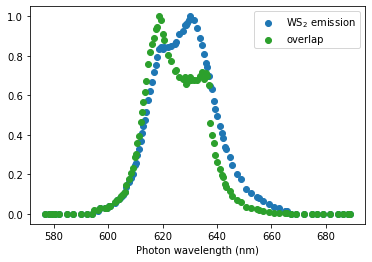

In [40]:
plt.clf()
plt.scatter(WS2_nm, WS2_intensity/WS2_intensity.max(), color="tab:blue", label="$\mathrm{WS}_2$ emission")
plt.scatter(lambda_J, J_OLI/J_OLI.max(), label="overlap", color="tab:green")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

## Förster distance

Now that we have the overlap integral, we can calculate the Förster distance from a few other parameters of the host material.

In [19]:
def forster_distance_OLI(kappa2, Phi_D, J, n):
    R6_0 = kappa2*Phi_D*J/(n**4)
    R_0 = 4.542*(R6_0)**(1./6.) # nm
    return R_0

Recall
$$
R_0^6 = \frac{9 (\ln 10) \kappa^2 \Phi_D J }{128\pi^5 n^4 N_A}
$$
which for OLI units is
$$
R_0 = 4.542 \left(\frac{\kappa^2 \Phi_D J }{n^4}\right)^{1/6}
$$

In [48]:
kappa2 = 2./3 # orientation factor for dipole interaction
# "The orientation factor takes on a value of κ² = 2/3 for a dynamic and
# isotropic distribution of donor and acceptor orientations"
# "Varies between 0 and 4."

n_diamond = 2.417 # index of refraction of diamond
# "All refractive index values in the literature are in the 1.33 - 1.6 range.
# The values 1.34 and 1.6 are the ones used most frequently."
# TODO: check if this correct at 532 nm.

Phi_D = 0.5 # quantum yield of WS2.
# TODO: find a better value for WS2 monolayer.
# "varies between 0 and 1"

R_0_nm = forster_distance_OLI(kappa2, Phi_D, J = J_sum_OLI, n = n_diamond)

print("R₀ = {:.4} nm".format(R_0_nm))

R₀ = 2.943 nm


## FRET efficiency

In [21]:
def FRET_efficiency(R_0, r_DA):
    # Need both in same units.
    R6_0 = R_0**6
    E = R6_0 / (R6_0 + r_DA**6)
    return E

We're interested in a range of donor-acceptor distances.

In [22]:
r_DA_range_nm = np.linspace(0.1, 10, num=100)

In [23]:
FRET_efficiencies_list = []
for r_DA_nm in r_DA_range_nm:
    E = FRET_efficiency(R_0_nm, r_DA_nm)
    FRET_efficiencies_list.append(E)
FRET_efficiencies = np.array(FRET_efficiencies_list)

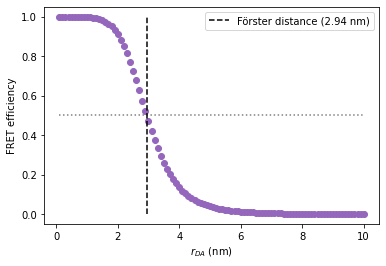

In [49]:
plt.clf()
plt.hlines(y=0.5, xmin=min(r_DA_range_nm), xmax=max(r_DA_range_nm), color="gray", linestyles="dotted")
plt.vlines(x=R_0_nm, ymin=0, ymax=1, color="black", linestyles="dashed", label="Förster distance ({:.3g} nm)".format(R_0_nm))
plt.scatter(r_DA_range_nm, FRET_efficiencies, color="tab:purple")
plt.xlabel("$r_{DA}$ (nm)")
plt.legend()
plt.ylabel("FRET efficiency");